In [1]:
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import os
import pickleslicer
from stoqcompiler.unitary import *
from stoqcompiler.verification import *

import jaqalpaq
from jaqalpaq.parser import parse_jaqal_string
from jaqalpaq.emulator import run_jaqal_circuit
from jaqalpaq.generator import generate_jaqal_program
from qscout.v1.native_gates import U_R, U_MS, U_Rz

## Define the 8-qubit system parameters

In [2]:
num_system_qubits = 8

qubit_dimension = 2
system_dimension = qubit_dimension ** num_system_qubits
qubits_to_use = [q for q in range(num_system_qubits)]

def qscout_r(max_angle):
    min_value = -max_angle
    max_value = max_angle
    parameters = [ParameterizedUnitaryParameter("Φ", -np.pi, np.pi, is_angle=True),
                  ParameterizedUnitaryParameter("θ", min_value, max_value, is_angle=True)]
    operation_name = "R"
    connectivity = [[q] for q in range(num_system_qubits)]
    allowed_apply_to = [apply_to for apply_to in connectivity if set(apply_to).issubset(set(qubits_to_use))]
    return UnitaryPrimitive(ParameterizedUnitary(qubit_dimension, U_R, parameters, operation_name), allowed_apply_to)

def qscout_rz(max_angle):
    min_value = -max_angle
    max_value = max_angle
    parameters = [ParameterizedUnitaryParameter("θ", min_value, max_value, is_angle=True)]
    operation_name = "Rz"
    connectivity = [[q] for q in range(num_system_qubits)]
    allowed_apply_to = [apply_to for apply_to in connectivity if set(apply_to).issubset(set(qubits_to_use))]
    return UnitaryPrimitive(ParameterizedUnitary(qubit_dimension, U_Rz, parameters, operation_name), allowed_apply_to)

def qscout_ms(max_angle):
    min_value = -max_angle
    max_value = max_angle
    dimension = 2
    parameters = [ParameterizedUnitaryParameter("Φ", -np.pi, np.pi, is_angle=True),
                  ParameterizedUnitaryParameter("θ", min_value, max_value, is_angle=True)]
    operation_name = "MS"
    connectivity = [[i,j] for i in range(num_system_qubits) for j in range(num_system_qubits) if i != j]
    allowed_apply_to = [apply_to for apply_to in connectivity if set(apply_to).issubset(set(qubits_to_use))]
    return UnitaryPrimitive(ParameterizedUnitary(qubit_dimension ** 2, U_MS, parameters, operation_name), allowed_apply_to)

## How RAV uncertainty scales with # of shots

- Choose a representative long-enough random RAV circuit with ideal output state $\lvert\psi\rangle \approx \sqrt{1-\epsilon} \lvert0\rangle + \sqrt{\epsilon} \lvert\textrm{other states}\rangle$
- Plot a whole bunch of points, x-axis = # shots, y-axis = initial state probability, for:
   - 100% ideal output state $2^n \cdot \rho = \lvert\psi\rangle\langle\psi\rvert$
   - 75% ideal output state $2^n \cdot \rho = \frac{3}{4} \lvert\psi\rangle\langle\psi\rvert + \frac{1}{4} I$
   - 50% ideal output state $2^n \cdot \rho = \frac{1}{2} \lvert\psi\rangle\langle\psi\rvert + \frac{1}{2} I$
   - 25% ideal output state $2^n \cdot \rho = \frac{1}{4} \lvert\psi\rangle\langle\psi\rvert + \frac{3}{4} I$
   - completely mixed output state $2^n \cdot \rho = I$

In [3]:
unitary_primitive_counts = {
    qscout_r(max_angle=np.pi/10): 3,
    qscout_rz(max_angle=np.pi/10): 3,
    qscout_ms(max_angle=np.pi/10): 1
}

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
directory = f"output_ideal_rav_vs_xeb_simulations/{timestamp}"
if not os.path.exists(directory):
    os.makedirs(directory)

In [4]:
sequence_count = 5
layer_count = 10

rav_results = []
for seq_idx in range(sequence_count):
    final_cost = 1.0
    while final_cost > 0.06:
        rav_result = Verification.generate_layered_rav_sequence(
            system_dimension,
            unitary_primitive_counts,
            layer_count,
            max_step_count = 10000,
            threshold = 1.0,
        )

        product = rav_result.compiled_sequence.product()
        identity = Unitary.identity(system_dimension)
        final_cost = product.distance_from(identity)

        print(f"generated circuit: length {rav_result.compiled_sequence.get_length()} with final cost {final_cost}")

    rav_results.append(rav_result)
    filename = f'{directory}/rav_{num_system_qubits}q_{layer_count}_{seq_idx}.txt'
    with open(filename, 'w') as f:
        f.write(f'''
    from qscout.v1.std usepulses *
    register q[{len(qubits_to_use)}]
    prepare_all
    ''')
        f.write(rav_result.compiled_sequence.get_jaqal())
        f.write(f'''
    measure_all
    ''')

    print(f"SUCCESS: wrote JAQAL circuit to {filename}")

generated circuit: length 182 with final cost 0.05352075728815642
SUCCESS: wrote JAQAL circuit to output_ideal_rav_vs_xeb_simulations/20220420_072324/rav_8q_10_0.txt
generated circuit: length 140 with final cost 0.06657422524307477
generated circuit: length 161 with final cost 0.08009700409104803
generated circuit: length 203 with final cost 0.07349294066379375
generated circuit: length 168 with final cost 0.050052773729425404
SUCCESS: wrote JAQAL circuit to output_ideal_rav_vs_xeb_simulations/20220420_072324/rav_8q_10_1.txt
generated circuit: length 112 with final cost 0.0659328197068727
generated circuit: length 147 with final cost 0.06894213191904575
generated circuit: length 126 with final cost 0.06512039289038007
generated circuit: length 119 with final cost 0.039212861606391924
SUCCESS: wrote JAQAL circuit to output_ideal_rav_vs_xeb_simulations/20220420_072324/rav_8q_10_2.txt
generated circuit: length 203 with final cost 0.07943466773219043
generated circuit: length 147 with fina

In [5]:
rav_x_data = {}
rav_y_data = {}    
for seq_idx, rav_result in enumerate(rav_results):
    rav_sequence_matrix = rav_result.compiled_sequence.product().get_matrix()

    mixed_state_fraction_list = [0.0, 0.25, 0.5, 0.75, 1.0]

    rav_x_data[seq_idx] = {}
    rav_y_data[seq_idx] = {}

    for i, mixed_state_fraction in enumerate(mixed_state_fraction_list):
        initial_state_index = 1

        # calculate the ideal output state
        initial_state = np.zeros(system_dimension)
        initial_state[initial_state_index] = 1
        initial_state = np.atleast_2d(initial_state).T
        ideal_output_state = rav_sequence_matrix @ initial_state
        #print("ideal_output_state coefficients:", np.round(ideal_output_state.T, 4))

        # validate the state
        ideal_output_probs = np.array([np.linalg.norm(c)**2 for c in ideal_output_state])
        #print("ideal_output_probs =", np.round(ideal_output_probs, 4))
        sum_of_probs = np.sum([np.linalg.norm(c)**2 for c in ideal_output_state])
        assert np.isclose(sum_of_probs, 1.0)

        # mix in the mixed state fraction
        mixed_state_output_probs = np.array([1/system_dimension for _ in range(system_dimension)])
        output_probs = np.add(
            (1-mixed_state_fraction) * ideal_output_probs,
            mixed_state_fraction * mixed_state_output_probs
        )
        print(f"mixed_state_fraction = {mixed_state_fraction}, output_probs = {np.round(output_probs, 4)}")

        # sample many times and plot
        n_shots_list = [25, 50, 100, 200, 400, 800, 1600, 3200, 6400]
        repetitions = 100
        rav_x_data[seq_idx][mixed_state_fraction] = []
        rav_y_data[seq_idx][mixed_state_fraction] = []
        for n_shots in n_shots_list:
            for _ in range(repetitions):
                measurements = [int(np.random.random() < output_probs[initial_state_index]) for _ in range(n_shots)]
                scaled_fidelity = (np.mean(measurements) - 1/system_dimension) * (system_dimension/(system_dimension-1))

                rav_x_data[seq_idx][mixed_state_fraction].append(n_shots)
                rav_y_data[seq_idx][mixed_state_fraction].append(scaled_fidelity)

mixed_state_fraction = 0.0, output_probs = [5.200e-03 9.026e-01 1.400e-03 3.100e-03 1.000e-04 1.400e-03 0.000e+00
 9.500e-03 0.000e+00 1.000e-04 0.000e+00 1.000e-03 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 8.800e-03 1.800e-03 1.000e-04 2.000e-04 0.000e+00
 0.000e+00 1.000e-04 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.900e-03 0.000e+00
 7.000e-03 0.000e+00 4.000e-04 0.000e+00 1.000e-04 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 1.000e-04 1.000e-04 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 7.000e-04 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 1.000e-04 7.100e-03 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 1.000e-04 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.0

mixed_state_fraction = 0.0, output_probs = [8.000e-03 9.099e-01 1.000e-04 2.400e-03 0.000e+00 1.100e-03 1.000e-04
 1.460e-02 1.000e-04 5.300e-03 1.000e-04 7.900e-03 0.000e+00 3.000e-04
 0.000e+00 1.000e-04 6.000e-04 1.900e-03 0.000e+00 7.800e-03 0.000e+00
 1.000e-04 0.000e+00 0.000e+00 0.000e+00 3.000e-04 0.000e+00 1.000e-04
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.100e-03 8.000e-04 0.000e+00
 2.000e-04 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 1.200e-03 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 1.000e-04 2.000e-04 2.100e-02 0.000e+00 4.000e-04
 0.000e+00 0.000e+00 0.000e+00 2.000e-04 0.000e+00 1.000e-04 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e-04 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.0

mixed_state_fraction = 0.0, output_probs = [9.000e-04 9.371e-01 0.000e+00 3.000e-03 0.000e+00 8.000e-04 0.000e+00
 0.000e+00 0.000e+00 2.700e-03 0.000e+00 0.000e+00 0.000e+00 1.400e-03
 0.000e+00 0.000e+00 1.000e-04 8.300e-03 0.000e+00 0.000e+00 0.000e+00
 3.100e-03 0.000e+00 0.000e+00 0.000e+00 3.000e-03 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 2.000e-04 5.000e-03 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.600e-03
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 1.900e-03 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 2.700e-03 5.300e-03 0.000e+00 1.440e-02 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e-04
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.0

mixed_state_fraction = 0.0, output_probs = [1.800e-03 9.116e-01 2.320e-02 3.000e-03 0.000e+00 6.100e-03 2.000e-04
 0.000e+00 1.300e-03 5.900e-03 2.000e-04 0.000e+00 0.000e+00 2.000e-04
 0.000e+00 0.000e+00 3.000e-04 6.100e-03 2.000e-04 3.600e-03 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 4.000e-03 1.000e-04 1.000e-04
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.490e-02 3.000e-04
 2.000e-04 0.000e+00 1.000e-04 0.000e+00 0.000e+00 0.000e+00 1.000e-04
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 1.000e-04 0.000e+00 1.000e-04 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 1.000e-04 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 9.000e-04 0.000e+00 3.600e-03 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.0

mixed_state_fraction = 0.0, output_probs = [2.400e-03 8.946e-01 7.000e-04 2.900e-03 0.000e+00 3.400e-03 0.000e+00
 1.000e-04 0.000e+00 4.100e-03 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 2.860e-02 4.200e-03 1.000e-04 6.800e-03 1.000e-04
 0.000e+00 0.000e+00 0.000e+00 1.000e-04 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 3.000e-04 4.000e-03 0.000e+00
 4.100e-03 0.000e+00 5.600e-03 0.000e+00 1.000e-04 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 2.000e-04
 1.000e-04 1.000e-04 0.000e+00 2.000e-04 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 1.000e-04 3.000e-03 0.000e+00 9.000e-04 0.000e+00 1.340e-02
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 1.000e-04 0.000e+00 0.000e+00 2.000e-04 5.900e-03 0.000e+00 0.000e+00
 4.000e-04 2.000e-04 0.000e+00 1.000e-04 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.0

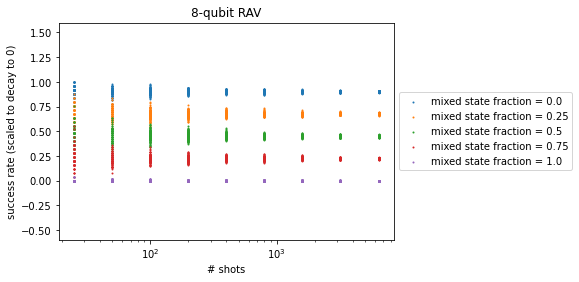

In [6]:
plt.figure(figsize=(6, 4))

for i, mixed_state_fraction in enumerate(mixed_state_fraction_list):
    plt.scatter(
        rav_x_data[0][mixed_state_fraction],
        rav_y_data[0][mixed_state_fraction],
        s=1, label=f'mixed state fraction = {mixed_state_fraction}')
    
plt.ylim(-0.6, 1.6)
plt.xscale('log')
plt.xlabel('# shots')
plt.ylabel('success rate (scaled to decay to 0)')
plt.title(f'{num_system_qubits}-qubit RAV')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [7]:
rav_std_data = {}
for seq_idx, rav_result in enumerate(rav_results):
    rav_std_data[seq_idx] = {}
    for i, mixed_state_fraction in enumerate(mixed_state_fraction_list):
        rav_std_data[seq_idx][mixed_state_fraction] = []    
        for n_shots in n_shots_list:
            current_slice = np.array(rav_x_data[seq_idx][mixed_state_fraction]) == n_shots
            y_vals = np.extract(current_slice, rav_y_data[seq_idx][mixed_state_fraction])
            rav_std_data[seq_idx][mixed_state_fraction].append(np.std(y_vals))

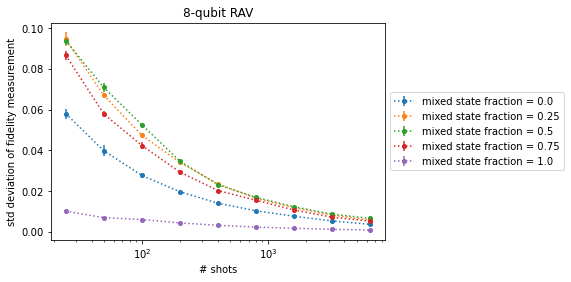

In [8]:
plt.figure(figsize=(6, 4))

for i, mixed_state_fraction in enumerate(mixed_state_fraction_list):
    y_raw = [rav_std_data[seq_idx][mixed_state_fraction] for seq_idx in rav_std_data]
    plt.errorbar(
        n_shots_list,
        y=np.mean(y_raw, axis=0),
        yerr=np.std(y_raw, axis=0) / np.sqrt(sequence_count),
        marker='.',
        markersize=8, label=f'mixed state fraction = {mixed_state_fraction}',
        linestyle='dotted')

plt.xscale('log')
plt.xlabel('# shots')
plt.ylabel('std deviation of fidelity measurement')
plt.title(f'{num_system_qubits}-qubit RAV')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## How XEB uncertainty scales with # of shots

- Choose a representative random circuit of same length used above for RAV with ideal output state $\lvert\phi\rangle$
- Plot a whole bunch of points, x-axis = # shots, y-axis = initial state probability, for:
   - 100% ideal output state $2^n \cdot \rho = \lvert\phi\rangle\langle\phi\rvert$
   - 75% ideal output state $2^n \cdot \rho = \frac{3}{4} \lvert\phi\rangle\langle\phi\rvert + \frac{1}{4} I$
   - 50% ideal output state $2^n \cdot \rho = \frac{1}{2} \lvert\phi\rangle\langle\phi\rvert + \frac{1}{2} I$
   - 25% ideal output state $2^n \cdot \rho = \frac{1}{4} \lvert\phi\rangle\langle\phi\rvert + \frac{3}{4} I$
   - completely mixed output state $2^n \cdot \rho = I$

In [9]:
xeb_results = []
for seq_idx in range(sequence_count):
    xeb_layer_count = rav_results[seq_idx].compiled_sequence.get_length() // int(sum(list(unitary_primitive_counts.values())))

    xeb_result = Verification.generate_layered_rav_sequence(
        system_dimension,
        unitary_primitive_counts,
        xeb_layer_count,
        max_step_count = 0,
        threshold = 0.0,
    )

    product = xeb_result.compiled_sequence.product()
    identity = Unitary.identity(system_dimension)
    final_cost = product.distance_from(identity)

    print(f"generated XEB circuit: length {xeb_result.compiled_sequence.get_length()} with final cost {final_cost}")

    xeb_results.append(xeb_result)

    filename = f'{directory}/xeb_{num_system_qubits}q_{xeb_layer_count}_{seq_idx}.txt'
    with open(filename, 'w') as f:
        f.write(f'''
    from qscout.v1.std usepulses *
    register q[{len(qubits_to_use)}]
    prepare_all
    ''')
        f.write(xeb_result.compiled_sequence.get_jaqal())
        f.write(f'''
    measure_all
    ''')

    print(f"SUCCESS: wrote JAQAL circuit to {filename}")

generated XEB circuit: length 182 with final cost 0.6787979716891046
SUCCESS: wrote JAQAL circuit to output_ideal_rav_vs_xeb_simulations/20220420_072324/xeb_8q_26_0.txt
generated XEB circuit: length 168 with final cost 0.3864564811364102
SUCCESS: wrote JAQAL circuit to output_ideal_rav_vs_xeb_simulations/20220420_072324/xeb_8q_24_1.txt
generated XEB circuit: length 119 with final cost 0.48049090880197043
SUCCESS: wrote JAQAL circuit to output_ideal_rav_vs_xeb_simulations/20220420_072324/xeb_8q_17_2.txt
generated XEB circuit: length 112 with final cost 0.32100571167811287
SUCCESS: wrote JAQAL circuit to output_ideal_rav_vs_xeb_simulations/20220420_072324/xeb_8q_16_3.txt
generated XEB circuit: length 133 with final cost 0.5248994896640673
SUCCESS: wrote JAQAL circuit to output_ideal_rav_vs_xeb_simulations/20220420_072324/xeb_8q_19_4.txt


In [10]:
xeb_x_data = {}
xeb_y_data = {}    
for seq_idx, xeb_result in enumerate(xeb_results):
    xeb_sequence_matrix = xeb_result.compiled_sequence.product().get_matrix()

    mixed_state_fraction_list = [0.0, 0.25, 0.5, 0.75, 1.0]

    xeb_x_data[seq_idx] = {}
    xeb_y_data[seq_idx] = {}

    for i, mixed_state_fraction in enumerate(mixed_state_fraction_list):
        initial_state_index = 1

        # calculate the ideal output state
        initial_state = np.zeros(system_dimension)
        initial_state[initial_state_index] = 1
        initial_state = np.atleast_2d(initial_state).T
        ideal_output_state = xeb_sequence_matrix @ initial_state
        #print("ideal_output_state coefficients:", np.round(ideal_output_state.T, 4))

        # validate the state
        ideal_output_probs = np.array([np.linalg.norm(c)**2 for c in ideal_output_state])
        #print("ideal_output_probs =", np.round(ideal_output_probs, 4))
        sum_of_probs = np.sum([np.linalg.norm(c)**2 for c in ideal_output_state])
        assert np.isclose(sum_of_probs, 1.0)

        # mix in the mixed state fraction
        mixed_state_output_probs = np.array([1/system_dimension for _ in range(system_dimension)])
        output_probs = np.add(
            (1-mixed_state_fraction) * ideal_output_probs,
            mixed_state_fraction * mixed_state_output_probs
        )
        print(f"mixed_state_fraction = {mixed_state_fraction}, output_probs = {np.round(output_probs, 4)}")

        # sample many times and plot
        n_shots_list = [25, 50, 100, 200, 400, 800, 1600, 3200, 6400]
        repetitions = 100
        xeb_x_data[seq_idx][mixed_state_fraction] = []
        xeb_y_data[seq_idx][mixed_state_fraction] = []
        for n_shots in n_shots_list:
            for _ in range(repetitions):
                measurements = [int(np.random.random() < output_probs[initial_state_index]) for _ in range(n_shots)]
                measurements = np.random.choice(system_dimension, size=n_shots, p=output_probs)
                measurement_probs = [np.count_nonzero(measurements == k) / n_shots for k in range(system_dimension)]
                assert np.isclose(np.sum(measurement_probs), 1.0)

                # calculate cross-entropy fidelity between ideal_output_probs, measurement_probs
                e_u = np.sum(ideal_output_probs**2)
                u_u = np.sum(ideal_output_probs) / system_dimension
                m_u = np.sum(ideal_output_probs * measurement_probs)
                y = m_u - u_u
                x = e_u - u_u
                fidelity = (x * y) / (x ** 2)

                xeb_x_data[seq_idx][mixed_state_fraction].append(n_shots)
                xeb_y_data[seq_idx][mixed_state_fraction].append(fidelity)

mixed_state_fraction = 0.0, output_probs = [2.733e-01 4.098e-01 1.650e-02 7.400e-03 1.310e-02 1.240e-02 8.000e-04
 1.800e-03 1.870e-02 2.340e-02 8.000e-04 8.000e-04 8.000e-04 8.000e-04
 1.000e-04 1.000e-04 5.200e-03 5.300e-03 2.000e-04 0.000e+00 8.000e-04
 9.000e-04 0.000e+00 0.000e+00 6.000e-04 1.000e-03 0.000e+00 0.000e+00
 1.000e-04 1.000e-04 0.000e+00 0.000e+00 3.000e-04 5.000e-04 2.500e-03
 5.500e-03 0.000e+00 0.000e+00 1.000e-04 1.000e-04 3.500e-03 4.700e-03
 1.000e-04 2.000e-04 2.000e-04 1.000e-04 0.000e+00 1.000e-04 2.900e-03
 4.900e-03 4.000e-04 2.000e-04 1.000e-04 2.000e-04 0.000e+00 0.000e+00
 2.000e-04 2.000e-04 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 2.100e-03 1.061e-01 2.000e-04 2.200e-03 1.000e-04 3.600e-03
 0.000e+00 6.000e-04 9.000e-04 4.000e-03 0.000e+00 2.000e-04 0.000e+00
 1.000e-04 0.000e+00 0.000e+00 7.000e-04 3.200e-03 0.000e+00 0.000e+00
 0.000e+00 4.000e-04 0.000e+00 0.000e+00 0.000e+00 3.000e-04 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.0

mixed_state_fraction = 0.0, output_probs = [2.380e-02 5.828e-01 4.800e-03 1.230e-02 7.000e-04 2.420e-02 2.000e-03
 1.950e-02 4.000e-04 1.700e-03 2.000e-04 2.400e-03 0.000e+00 3.000e-04
 0.000e+00 1.000e-04 1.400e-02 7.700e-03 1.000e-04 6.000e-04 1.000e-04
 5.300e-03 3.000e-04 9.000e-04 1.000e-04 6.800e-03 0.000e+00 1.000e-04
 0.000e+00 4.000e-04 0.000e+00 3.000e-04 2.800e-03 3.510e-02 2.000e-04
 1.000e-03 1.000e-04 1.400e-03 2.000e-04 1.300e-03 5.000e-04 1.430e-02
 2.000e-04 5.000e-04 0.000e+00 7.000e-04 1.000e-04 6.000e-04 9.000e-04
 1.000e-02 0.000e+00 1.000e-04 0.000e+00 7.000e-04 0.000e+00 4.000e-04
 2.000e-04 3.000e-04 0.000e+00 0.000e+00 0.000e+00 2.000e-04 0.000e+00
 0.000e+00 1.300e-03 3.610e-02 1.000e-04 1.200e-03 6.000e-04 7.500e-03
 1.000e-04 3.100e-03 0.000e+00 3.000e-04 0.000e+00 2.000e-04 0.000e+00
 0.000e+00 0.000e+00 1.000e-04 1.200e-03 1.200e-03 0.000e+00 4.000e-04
 3.000e-04 1.100e-03 1.000e-04 2.000e-04 0.000e+00 3.000e-04 0.000e+00
 0.000e+00 0.000e+00 1.000e-04 0.0

mixed_state_fraction = 1.0, output_probs = [0.0039 0.0039 0.0039 0.0039 0.0039 0.0039 0.0039 0.0039 0.0039 0.0039
 0.0039 0.0039 0.0039 0.0039 0.0039 0.0039 0.0039 0.0039 0.0039 0.0039
 0.0039 0.0039 0.0039 0.0039 0.0039 0.0039 0.0039 0.0039 0.0039 0.0039
 0.0039 0.0039 0.0039 0.0039 0.0039 0.0039 0.0039 0.0039 0.0039 0.0039
 0.0039 0.0039 0.0039 0.0039 0.0039 0.0039 0.0039 0.0039 0.0039 0.0039
 0.0039 0.0039 0.0039 0.0039 0.0039 0.0039 0.0039 0.0039 0.0039 0.0039
 0.0039 0.0039 0.0039 0.0039 0.0039 0.0039 0.0039 0.0039 0.0039 0.0039
 0.0039 0.0039 0.0039 0.0039 0.0039 0.0039 0.0039 0.0039 0.0039 0.0039
 0.0039 0.0039 0.0039 0.0039 0.0039 0.0039 0.0039 0.0039 0.0039 0.0039
 0.0039 0.0039 0.0039 0.0039 0.0039 0.0039 0.0039 0.0039 0.0039 0.0039
 0.0039 0.0039 0.0039 0.0039 0.0039 0.0039 0.0039 0.0039 0.0039 0.0039
 0.0039 0.0039 0.0039 0.0039 0.0039 0.0039 0.0039 0.0039 0.0039 0.0039
 0.0039 0.0039 0.0039 0.0039 0.0039 0.0039 0.0039 0.0039 0.0039 0.0039
 0.0039 0.0039 0.0039 0.0039 0.003

mixed_state_fraction = 0.75, output_probs = [0.0175 0.119  0.0062 0.0229 0.0031 0.0038 0.0032 0.0052 0.0031 0.0037
 0.0029 0.003  0.003  0.0031 0.0029 0.003  0.0037 0.0107 0.0034 0.0058
 0.0029 0.0031 0.003  0.0031 0.0029 0.003  0.0029 0.003  0.0029 0.0029
 0.0029 0.0029 0.0055 0.0251 0.0032 0.0045 0.003  0.0037 0.003  0.0035
 0.0033 0.0057 0.003  0.0035 0.0029 0.003  0.0029 0.003  0.0031 0.0043
 0.003  0.0033 0.0029 0.003  0.0029 0.0029 0.003  0.0032 0.0029 0.003
 0.0029 0.0029 0.0029 0.0029 0.0052 0.0126 0.0031 0.0082 0.003  0.0037
 0.003  0.0034 0.0033 0.0068 0.003  0.0038 0.0029 0.003  0.0029 0.003
 0.0035 0.0042 0.0031 0.0034 0.0029 0.003  0.0029 0.003  0.0029 0.0031
 0.0029 0.003  0.0029 0.0029 0.0029 0.0029 0.0036 0.0055 0.003  0.0037
 0.0029 0.0031 0.0029 0.0031 0.0031 0.0032 0.0029 0.003  0.0029 0.0029
 0.0029 0.0029 0.0031 0.0033 0.0029 0.003  0.0029 0.0029 0.0029 0.0029
 0.003  0.0031 0.0029 0.003  0.0029 0.0029 0.0029 0.0029 0.0049 0.0066
 0.0033 0.0036 0.003  0.0037 0.0029

mixed_state_fraction = 0.5, output_probs = [0.0178 0.3144 0.002  0.0041 0.0025 0.0082 0.002  0.002  0.0025 0.0134
 0.002  0.002  0.002  0.0025 0.002  0.002  0.004  0.0175 0.0024 0.0099
 0.002  0.0031 0.002  0.0021 0.002  0.0025 0.002  0.0022 0.002  0.002
 0.002  0.002  0.004  0.0416 0.0023 0.01   0.002  0.0028 0.002  0.0021
 0.002  0.0034 0.002  0.0022 0.002  0.002  0.002  0.002  0.0021 0.0048
 0.0021 0.0033 0.002  0.0021 0.002  0.002  0.002  0.0021 0.002  0.002
 0.002  0.002  0.002  0.002  0.002  0.0354 0.0022 0.0072 0.002  0.0026
 0.002  0.0021 0.002  0.0032 0.002  0.0021 0.002  0.002  0.002  0.002
 0.0023 0.0055 0.002  0.0037 0.002  0.0021 0.002  0.002  0.002  0.0021
 0.002  0.002  0.002  0.002  0.002  0.002  0.002  0.008  0.002  0.0025
 0.002  0.0021 0.002  0.002  0.002  0.0022 0.002  0.002  0.002  0.002
 0.002  0.002  0.002  0.003  0.002  0.0024 0.002  0.002  0.002  0.002
 0.002  0.002  0.002  0.002  0.002  0.002  0.002  0.002  0.002  0.0024
 0.0021 0.0041 0.002  0.002  0.002  0.0

mixed_state_fraction = 0.25, output_probs = [0.0019 0.4402 0.0061 0.0073 0.001  0.0261 0.0013 0.0026 0.001  0.0134
 0.0012 0.0011 0.001  0.0017 0.001  0.001  0.0012 0.0569 0.0016 0.0022
 0.001  0.0045 0.001  0.0012 0.001  0.0021 0.001  0.001  0.001  0.0011
 0.001  0.001  0.0026 0.0098 0.0013 0.0231 0.0011 0.0028 0.001  0.0026
 0.001  0.0012 0.001  0.0016 0.001  0.001  0.001  0.001  0.0012 0.0015
 0.001  0.0039 0.001  0.001  0.001  0.0012 0.001  0.001  0.001  0.001
 0.001  0.001  0.001  0.001  0.0038 0.0191 0.0015 0.0013 0.0012 0.0019
 0.001  0.0011 0.001  0.0114 0.0011 0.0011 0.001  0.0015 0.001  0.001
 0.0014 0.0018 0.001  0.001  0.001  0.0013 0.001  0.001  0.001  0.002
 0.001  0.001  0.001  0.0011 0.001  0.001  0.0014 0.0058 0.0013 0.0021
 0.001  0.0011 0.001  0.001  0.001  0.0013 0.001  0.0015 0.001  0.001
 0.001  0.001  0.001  0.0019 0.001  0.001  0.001  0.001  0.001  0.001
 0.001  0.001  0.001  0.001  0.001  0.001  0.001  0.001  0.001  0.0324
 0.0014 0.0016 0.001  0.0022 0.001  0.

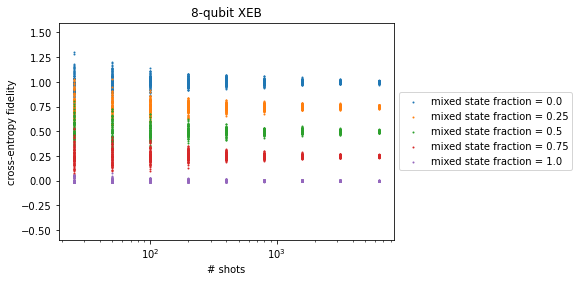

In [11]:
plt.figure(figsize=(6, 4))

for i, mixed_state_fraction in enumerate(mixed_state_fraction_list):
    plt.scatter(
        xeb_x_data[0][mixed_state_fraction],
        xeb_y_data[0][mixed_state_fraction],
        s=1, label=f'mixed state fraction = {mixed_state_fraction}')

plt.ylim(-0.6, 1.6)
plt.xscale('log')
plt.xlabel('# shots')
plt.ylabel('cross-entropy fidelity')
plt.title(f'{num_system_qubits}-qubit XEB')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [12]:
xeb_std_data = {}
for seq_idx, xeb_result in enumerate(xeb_results):
    xeb_std_data[seq_idx] = {}
    for i, mixed_state_fraction in enumerate(mixed_state_fraction_list):
        xeb_std_data[seq_idx][mixed_state_fraction] = []    
        for n_shots in n_shots_list:
            current_slice = np.array(xeb_x_data[seq_idx][mixed_state_fraction]) == n_shots
            y_vals = np.extract(current_slice, xeb_y_data[seq_idx][mixed_state_fraction])
            xeb_std_data[seq_idx][mixed_state_fraction].append(np.std(y_vals))

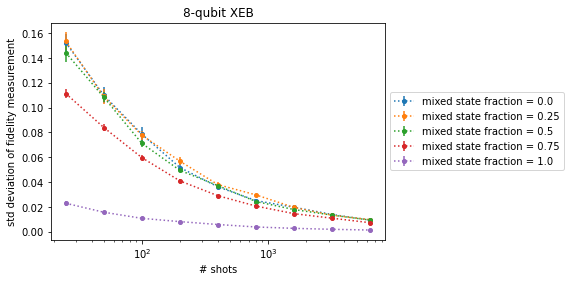

In [13]:
plt.figure(figsize=(6, 4))

for i, mixed_state_fraction in enumerate(mixed_state_fraction_list):
    y_raw = [xeb_std_data[seq_idx][mixed_state_fraction] for seq_idx in xeb_std_data]
    plt.errorbar(
        n_shots_list,
        y=np.mean(y_raw, axis=0),
        yerr=np.std(y_raw, axis=0) / np.sqrt(sequence_count),
        marker='.',
        markersize=8, label=f'mixed state fraction = {mixed_state_fraction}',
        linestyle='dotted')

plt.xscale('log')
plt.xlabel('# shots')
plt.ylabel('std deviation of fidelity measurement')
plt.title(f'{num_system_qubits}-qubit XEB')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [14]:
save_data = {
    "mixed_state_fraction_list": mixed_state_fraction_list,
    "n_shots_list": n_shots_list,
    "rav_x_data": rav_x_data,
    "rav_y_data": rav_y_data,
    "rav_std_data": rav_std_data,
    "xeb_x_data": xeb_x_data,
    "xeb_y_data": xeb_y_data,
    "xeb_std_data": xeb_std_data,
}
pickleslicer.dump(save_data, f'{directory}/ideal_rav_vs_xeb_simulations_{num_system_qubits}q.pickle')
print(f'Saved to {directory}/ideal_rav_vs_xeb_simulations_{num_system_qubits}q.pickle')

Saved to output_ideal_rav_vs_xeb_simulations/20220420_072324/ideal_rav_vs_xeb_simulations_8q.pickle


In [16]:
directory = 'output_ideal_rav_vs_xeb_simulations/20220420_072324'
load_data = pickleslicer.load(f'{directory}/ideal_rav_vs_xeb_simulations_{num_system_qubits}q.pickle')
mixed_state_fraction_list = load_data["mixed_state_fraction_list"]
n_shots_list = load_data["n_shots_list"]
rav_x_data = load_data["rav_x_data"]
rav_y_data = load_data["rav_y_data"]
rav_std_data = load_data["rav_std_data"]
xeb_x_data = load_data["xeb_x_data"]
xeb_y_data = load_data["xeb_y_data"]
xeb_std_data = load_data["xeb_std_data"]